# Pokemon Type Classification using Image

In [26]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


##Import necessary libraries.

In [27]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile, copy2,rmtree


import tensorflow as tf
import cv2
import os
from os import listdir
from os.path import isfile, join
from sklearn.metrics import RocCurveDisplay,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

## Read the structured data regarding on the images.

In [28]:
df = pd.read_csv("/content/gdrive/My Drive/DataAnalysis/Pokemon/pokemon.csv")

In [29]:
df.head(-1)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
803,naganadel,Poison,Dragon
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN


As we Pokemon fans know some pokemons only contain one Type which can be a little problematic for some built-in models that we are going to use.

Let's get filenames regarding on the images.

In [30]:
DIR_IMAGE = "/content/gdrive/My Drive/DataAnalysis/Pokemon/images/images" 
FILEs=[] 
for file in listdir(DIR_IMAGE): 
  if(isfile(join(DIR_IMAGE,file))): 
    FILEs.append(file)
df["images"] = pd.Series()
new = pd.DataFrame()
for FILE in FILEs:
  POK_NAME = FILE[:-4]
  df.loc[df['Name'] == POK_NAME,"images"]=FILE
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,Name,Type1,Type2,images
0,bulbasaur,Grass,Poison,bulbasaur.png
1,ivysaur,Grass,Poison,ivysaur.png
2,venusaur,Grass,Poison,venusaur.png
3,charmander,Fire,NaN,charmander.png
4,charmeleon,Fire,NaN,charmeleon.png


### Distribution of pokemons.

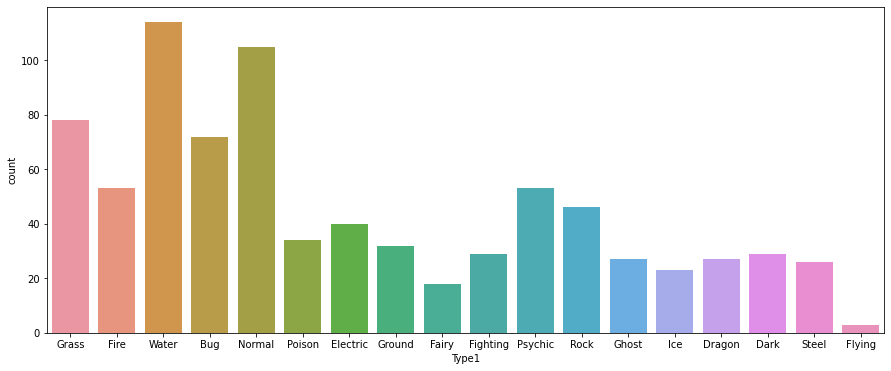

In [31]:
fig = plt.figure(figsize=(15,6))
ax=sns.countplot(df.Type1,data=df)

In [32]:
select = ['Water' , 'Grass']
df = df[df['Type1'].isin(select)]

Let's first try to evaluate on Water and Grass pokemons.

## Data Preprocessing

In [33]:
rmtree('train/')
rmtree('test/')
rmtree('val/')
os.makedirs('/content/gdrive/My Drive/DataAnalysis/Pokemon/train/',exist_ok=True)
os.makedirs('/content/gdrive/My Drive/DataAnalysis/Pokemon/test/',exist_ok=True)
os.makedirs('/content/gdrive/My Drive/DataAnalysis/Pokemon/val/',exist_ok=True)
for class_ in df['Type1'].unique():
    os.makedirs('train/'+str(class_)+'/',exist_ok=True)
    os.makedirs('test/'+str(class_)+'/',exist_ok=True)
    os.makedirs('val/'+str(class_)+'/',exist_ok=True)

Directories for test,train and val data.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df, df['Type1'],test_size=0.33, stratify=df['Type1'],random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33,stratify=y_test)

In [35]:
for image,type_  in zip(X_train['images'], y_train):
    copy2(join(DIR_IMAGE,image), 'train/'+type_)

for image,type_ in zip(X_test['images'], y_test):
    copy2(join(DIR_IMAGE,image), 'test/'+type_)

for image,type_ in zip(X_val['images'], y_val):
    copy2(join(DIR_IMAGE,image), 'val/'+type_)

In [36]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

Found 128 images belonging to 2 classes.
Found 42 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


## Swiss Knife:Resnet50

In [37]:
#resnet50
resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',input_shape= (256,256,3)
)
for layer in resnet50.layers:
    layer.trainable = False

In [38]:

x = resnet50.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.7)(x)
predictions = tf.keras.layers.Dense(2, activation= 'softmax')(x)
model = tf.keras.Model(inputs = resnet50.input, outputs = predictions)

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [40]:
history = model.fit_generator(train,
                              epochs=5,
                              validation_data=val
                             )

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/5
4/4 [==============================] - 27s 7s/step - loss: 1.5204 - accuracy: 0.5000 - val_loss: 0.8437 - val_accuracy: 0.5455
Epoch 2/5
4/4 [==============================] - 22s 6s/step - loss: 1.0697 - accuracy: 0.5938 - val_loss: 0.7640 - val_accuracy: 0.6364
Epoch 3/5
4/4 [==============================] - 22s 6s/step - loss: 0.9063 - accuracy: 0.6797 - val_loss: 0.6338 - val_accuracy: 0.6818
Epoch 4/5
4/4 [==============================] - 22s 6s/step - loss: 1.0709 - accuracy: 0.6016 - val_loss: 0.5624 - val_accuracy: 0.7273
Epoch 5/5
4/4 [==============================] - 23s 6s/step - loss: 0.9370 - accuracy: 0.5859 - val_loss: 0.5509 - val_accuracy: 0.6818


In [41]:
predict_frame = pd.DataFrame([])
predict = model.predict_generator(test)
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


              precision    recall  f1-score   support

       Grass       0.60      0.18      0.27        17
       Water       0.62      0.92      0.74        25

    accuracy                           0.62        42
   macro avg       0.61      0.55      0.51        42
weighted avg       0.61      0.62      0.55        42



Channels regarding on the two distributed data causes the main problem since we can not evaluate a model just from their shapes(Pokemons do not allow us to create a discriminative model by their shapes so edges are not effective as colors).



In [42]:
for image,type_ in zip(X_val['images'], y_val):
    copy2('val/'+type_+"/"+image,'train/'+type_)

In [43]:
train = datagen.flow_from_directory('train/')


Found 150 images belonging to 2 classes.


In [44]:
history = model.fit_generator(train,
                              epochs=5,
                             )

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5/5 [==============================] - 22s 4s/step - loss: 0.9193 - accuracy: 0.6533
Epoch 2/5
5/5 [==============================] - 22s 4s/step - loss: 0.5825 - accuracy: 0.7400
Epoch 3/5
5/5 [==============================] - 22s 4s/step - loss: 0.6986 - accuracy: 0.6933
Epoch 4/5
5/5 [==============================] - 24s 5s/step - loss: 0.6592 - accuracy: 0.7333
Epoch 5/5
5/5 [==============================] - 22s 4s/step - loss: 0.5695 - accuracy: 0.7267


In [45]:
predict_frame = pd.DataFrame([])
predict = model.predict_generator(test)
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


              precision    recall  f1-score   support

       Grass       0.45      0.29      0.36        17
       Water       0.61      0.76      0.68        25

    accuracy                           0.57        42
   macro avg       0.53      0.53      0.52        42
weighted avg       0.55      0.57      0.55        42



We are now able to correctly identify 2 pokemons max out of 3 pokemons and only for (Grass vs Fire).

In [46]:
resnet152 = tf.keras.applications.ResNet152(
    include_top=False, weights='imagenet',input_shape= (256,256,3)
)
for layer in resnet152.layers:
    layer.trainable = False

In [47]:
x = resnet152.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.7)(x)
predictions = tf.keras.layers.Dense(2, activation= 'softmax')(x)
model = tf.keras.Model(inputs = resnet152.input, outputs = predictions)

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [51]:
history = model.fit_generator(train,
                              epochs=5,
                             )

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/5
5/5 [==============================] - 62s 12s/step - loss: 0.7059 - accuracy: 0.7200
Epoch 2/5
5/5 [==============================] - 61s 12s/step - loss: 0.6646 - accuracy: 0.7400
Epoch 3/5
5/5 [==============================] - 66s 13s/step - loss: 0.5761 - accuracy: 0.7533
Epoch 4/5
5/5 [==============================] - 61s 12s/step - loss: 0.5318 - accuracy: 0.7733
Epoch 5/5
5/5 [==============================] - 61s 12s/step - loss: 0.7524 - accuracy: 0.6933


In [52]:
predict_frame = pd.DataFrame([])
predict = model.predict_generator(test)
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


              precision    recall  f1-score   support

       Grass       0.89      0.47      0.62        17
       Water       0.73      0.96      0.83        25

    accuracy                           0.76        42
   macro avg       0.81      0.72      0.72        42
weighted avg       0.79      0.76      0.74        42



It was a cheap shot but was worth it.This notebook needs more work.